### the cell downloads the required packages which are duckdb pyarrow and polars

In [ ]:
!pip install duckdb pyarrow polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 166.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 110.4 MB/s eta 0:00:00


### mounts your Google Drive to the Colab environment, allowing  access to files stored in your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### This cell uses the Polars library to scan the CSV file and display its column names. The scan_csv function allows for lazy evaluation, which is efficient for large files.

In [ ]:
import polars as pl
pl.scan_csv("/content/drive/MyDrive/extracted_archive/itineraries.csv").columns

/tmp/ipython-input-3-2679144785.py:2: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  pl.scan_csv("/content/drive/MyDrive/extracted_archive/itineraries.csv").columns


['legId',
 'searchDate',
 'flightDate',
 'startingAirport',
 'destinationAirport',
 'fareBasisCode',
 'travelDuration',
 'elapsedDays',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDepartureTimeEpochSeconds',
 'segmentsDepartureTimeRaw',
 'segmentsArrivalTimeEpochSeconds',
 'segmentsArrivalTimeRaw',
 'segmentsArrivalAirportCode',
 'segmentsDepartureAirportCode',
 'segmentsAirlineName',
 'segmentsAirlineCode',
 'segmentsEquipmentDescription',
 'segmentsDurationInSeconds',
 'segmentsDistance',
 'segmentsCabinCode']

### This cell uses the DuckDB library to read the CSV file and display its column names. DuckDB is an in-process SQL OLAP database system.

In [ ]:
import duckdb
duckdb.sql("SELECT * FROM read_csv_auto('/content/drive/MyDrive/extracted_archive/itineraries.csv') LIMIT 0").df().columns.tolist()

['legId',
 'searchDate',
 'flightDate',
 'startingAirport',
 'destinationAirport',
 'fareBasisCode',
 'travelDuration',
 'elapsedDays',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDepartureTimeEpochSeconds',
 'segmentsDepartureTimeRaw',
 'segmentsArrivalTimeEpochSeconds',
 'segmentsArrivalTimeRaw',
 'segmentsArrivalAirportCode',
 'segmentsDepartureAirportCode',
 'segmentsAirlineName',
 'segmentsAirlineCode',
 'segmentsEquipmentDescription',
 'segmentsDurationInSeconds',
 'segmentsDistance',
 'segmentsCabinCode']

### This cell defines the paths for the input CSV file and the output directory for storing data in the Parquet format.

In [ ]:
CSV_SRC = "/content/drive/MyDrive/extracted_archive/itineraries.csv"   # or "/content/drive/MyDrive/flightprices/*.csv"
OUT_PARQUET_DIR = "/content/drive/MyDrive/extracted_archive/flightprices_parquet"   # will be created if not present


### This cell defines a variable SRC with the path to the input CSV file.

In [ ]:
SRC = '/content/data/itineraries.csv'

### This cell initializes a DuckDB database connection and creates two views: fp_raw for a raw read of the CSV with all columns as VARCHAR, and fp for a typed view with appropriate data types cast from the raw data. It also sets PRAGMA threads and memory limits for better performance.

In [ ]:
# 3) Read directly from Drive and define views (no local copy)
import duckdb, os
con = duckdb.connect()

# Safer: set an explicit thread count; avoid 'ALL'
try:
    nthreads = max(1, os.cpu_count() or 2)
    con.execute(f"PRAGMA threads={nthreads}")
except Exception as e:
    print("Skipping PRAGMA threads:", e)

# Optional memory hint (ignored on some builds)
try:
    con.execute("SET memory_limit='80%'")
except Exception:
    pass

# Escape the path for SQL string literal
src_escaped = SRC.replace("'", "''")

# RAW view — robust read (all text), skips malformed rows
con.sql(f"""
CREATE OR REPLACE VIEW fp_raw AS
SELECT *
FROM read_csv_auto(
  '{src_escaped}',
  header = TRUE,
  all_varchar = TRUE,
  ignore_errors = TRUE,
  sample_size = 2000000
)
""")

# TYPED view — cast your 27 known columns
con.sql("""
CREATE OR REPLACE VIEW fp AS
SELECT
  CAST(legId AS VARCHAR)                                   AS legId,
  TRY_CAST(searchDate AS DATE)                             AS searchDate,
  TRY_CAST(flightDate AS DATE)                             AS flightDate,
  CAST(startingAirport AS VARCHAR)                         AS startingAirport,
  CAST(destinationAirport AS VARCHAR)                      AS destinationAirport,
  CAST(fareBasisCode AS VARCHAR)                           AS fareBasisCode,
  TRY_CAST(travelDuration AS INTEGER)                      AS travelDuration,
  TRY_CAST(elapsedDays AS INTEGER)                         AS elapsedDays,

  CASE
    WHEN lower(trim(CAST(isBasicEconomy AS VARCHAR))) IN ('1','true','t','yes','y') THEN TRUE
    WHEN lower(trim(CAST(isBasicEconomy AS VARCHAR))) IN ('0','false','f','no','n') THEN FALSE
    ELSE TRY_CAST(isBasicEconomy AS BOOLEAN)
  END                                                      AS isBasicEconomy,

  CASE
    WHEN lower(trim(CAST(isRefundable AS VARCHAR))) IN ('1','true','t','yes','y') THEN TRUE
    WHEN lower(trim(CAST(isRefundable AS VARCHAR))) IN ('0','false','f','no','n') THEN FALSE
    ELSE TRY_CAST(isRefundable AS BOOLEAN)
  END                                                      AS isRefundable,

  CASE
    WHEN lower(trim(CAST(isNonStop AS VARCHAR))) IN ('1','true','t','yes','y') THEN TRUE
    WHEN lower(trim(CAST(isNonStop AS VARCHAR))) IN ('0','false','f','no','n') THEN FALSE
    ELSE TRY_CAST(isNonStop AS BOOLEAN)
  END                                                      AS isNonStop,

  TRY_CAST(baseFare AS DOUBLE)                             AS baseFare,
  TRY_CAST(totalFare AS DOUBLE)                            AS totalFare,
  TRY_CAST(seatsRemaining AS INTEGER)                      AS seatsRemaining,
  TRY_CAST(totalTravelDistance AS DOUBLE)                  AS totalTravelDistance,

  CAST(segmentsDepartureTimeEpochSeconds AS VARCHAR)       AS segmentsDepartureTimeEpochSeconds,
  CAST(segmentsDepartureTimeRaw AS VARCHAR)                AS segmentsDepartureTimeRaw,
  CAST(segmentsArrivalTimeEpochSeconds AS VARCHAR)         AS segmentsArrivalTimeEpochSeconds,
  CAST(segmentsArrivalTimeRaw AS VARCHAR)                  AS segmentsArrivalTimeRaw,
  CAST(segmentsArrivalAirportCode AS VARCHAR)              AS segmentsArrivalAirportCode,
  CAST(segmentsDepartureAirportCode AS VARCHAR)            AS segmentsDepartureAirportCode,
  CAST(segmentsAirlineName AS VARCHAR)                     AS segmentsAirlineName,
  CAST(segmentsAirlineCode AS VARCHAR)                     AS segmentsAirlineCode,
  CAST(segmentsEquipmentDescription AS VARCHAR)            AS segmentsEquipmentDescription,
  TRY_CAST(segmentsDurationInSeconds AS INTEGER)           AS segmentsDurationInSeconds,
  TRY_CAST(segmentsDistance AS DOUBLE)                     AS segmentsDistance,
  CAST(segmentsCabinCode AS VARCHAR)                       AS segmentsCabinCode
FROM fp_raw
""")

print("✅ Views ready: fp_raw (all text) and fp (typed).")


✅ Views ready: fp_raw (all text) and fp (typed).


### This cell performs a quick exploratory data analysis (EDA) by querying the fp view to get the total number of rows.

In [ ]:
# 4) Quick EDA (runs directly on Drive CSV via DuckDB)
# Total rows
print("Total rows:", con.sql("SELECT COUNT(*) FROM fp").fetchone()[0])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total rows: 82138753


### This cell continues the quick EDA by showing the schema of the fp view, displaying the first 5 rows, and listing the top 10 airlines by frequency.

In [ ]:
# Schema
con.sql("DESCRIBE fp").show()

# Samples
con.sql("SELECT * FROM fp LIMIT 5").show()

# Top airlines
con.sql("""
SELECT segmentsAirlineCode AS airline, COUNT(*) AS n
FROM fp
GROUP BY 1
ORDER BY n DESC
LIMIT 10
""").show()

┌─────────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│           column_name           │ column_type │  null   │   key   │ default │  extra  │
│             varchar             │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ legId                           │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ searchDate                      │ DATE        │ YES     │ NULL    │ NULL    │ NULL    │
│ flightDate                      │ DATE        │ YES     │ NULL    │ NULL    │ NULL    │
│ startingAirport                 │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ destinationAirport              │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ fareBasisCode                   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ travelDuration                  │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
│ elapsedD

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ airline │    n     │
│ varchar │  int64   │
├─────────┼──────────┤
│ AA||AA  │ 16296340 │
│ DL||DL  │ 11351669 │
│ UA||UA  │ 10217320 │
│ AA      │  7453245 │
│ DL      │  4855169 │
│ UA      │  4531426 │
│ NK||NK  │  4215514 │
│ B6      │  3578393 │
│ B6||B6  │  3129646 │
│ AS||AS  │  1777996 │
├─────────┴──────────┤
│ 10 rows  2 columns │
└────────────────────┘



### This cell calculates and displays the daily average total fare for the first 10 days in the dataset using the fp view.

In [ ]:
# Daily avg fare (first 10 days)
con.sql("""
SELECT flightDate, AVG(totalFare) AS avg_total_fare, COUNT(*) AS n
FROM fp
WHERE totalFare IS NOT NULL
GROUP BY 1
ORDER BY 1
LIMIT 10
""").show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────────────────┬────────┐
│ flightDate │   avg_total_fare   │   n    │
│    date    │       double       │ int64  │
├────────────┼────────────────────┼────────┤
│ 2022-04-17 │  429.5632840881938 │   8258 │
│ 2022-04-18 │ 397.35498729125067 │  16524 │
│ 2022-04-19 │    333.39831867634 │  30702 │
│ 2022-04-20 │  330.4788972199589 │  41078 │
│ 2022-04-21 │  365.4598513773035 │  45888 │
│ 2022-04-22 │  389.7820920126249 │  53384 │
│ 2022-04-23 │  406.4653727910525 │  53475 │
│ 2022-04-24 │  524.2467111496226 │  51930 │
│ 2022-04-25 │  387.8612698096137 │  70168 │
│ 2022-04-26 │ 303.55307579472947 │ 107712 │
├────────────┴────────────────────┴────────┤
│ 10 rows                        3 columns │
└──────────────────────────────────────────┘



### This cell imports the matplotlib.pyplot library and sets default parameters for figure size and grid display for plotting.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.grid"] = True

### This cell imports the `seaborn` library, which is used for creating statistical graphics.

In [ ]:
import seaborn as sns

### This cell queries the `fp` view to get the top 20 airlines by flight count and visualizes the result as a bar plot using Seaborn.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

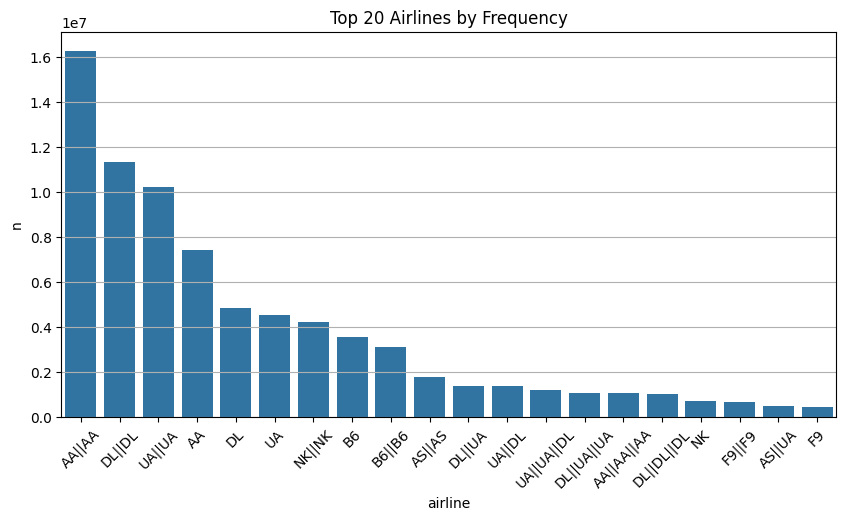

In [ ]:
# Airline market share
df_airline = con.sql("""
    SELECT segmentsAirlineCode AS airline, COUNT(*) AS n
    FROM fp
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
""").df()

# Bar plot
plt.figure(figsize=(10,5))
sns.barplot(data=df_airline, x="airline", y="n")
plt.xticks(rotation=45)
plt.title("Top 20 Airlines by Frequency")
plt.show()

### This cell samples the `fp` view to get `isRefundable` and `totalFare` columns and creates a box plot using Seaborn to visualize the distribution of total fare for refundable and non-refundable tickets.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

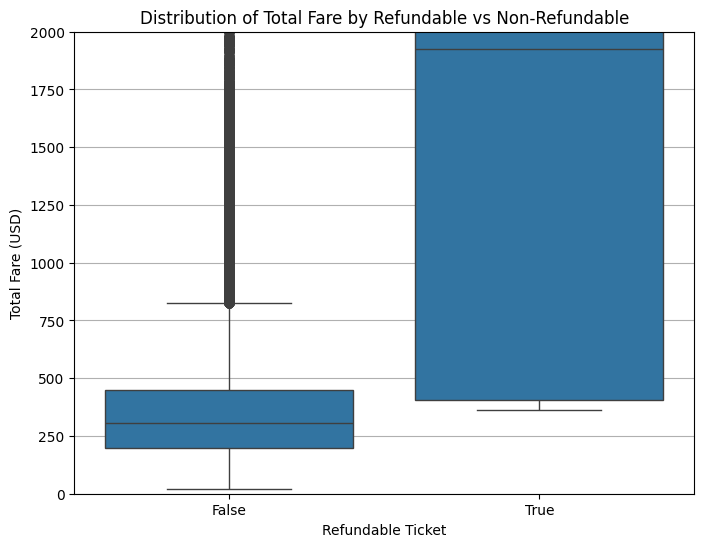

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Query: sample fares grouped by refundability
df_ref = con.sql("""
    SELECT
        isRefundable,
        totalFare
    FROM fp
    USING SAMPLE 500000
""").df()

# Plot
plt.figure(figsize=(8,6))
sns.boxplot(data=df_ref, x="isRefundable", y="totalFare")
plt.title("Distribution of Total Fare by Refundable vs Non-Refundable")
plt.xlabel("Refundable Ticket")
plt.ylabel("Total Fare (USD)")
plt.ylim(0, 2000)  # optional: cap extreme outliers
plt.show()


### This cell queries the `fp` view to get `isBasicEconomy` and `totalFare` columns and creates a box plot using Seaborn to visualize the distribution of total fare for basic economy and regular tickets.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

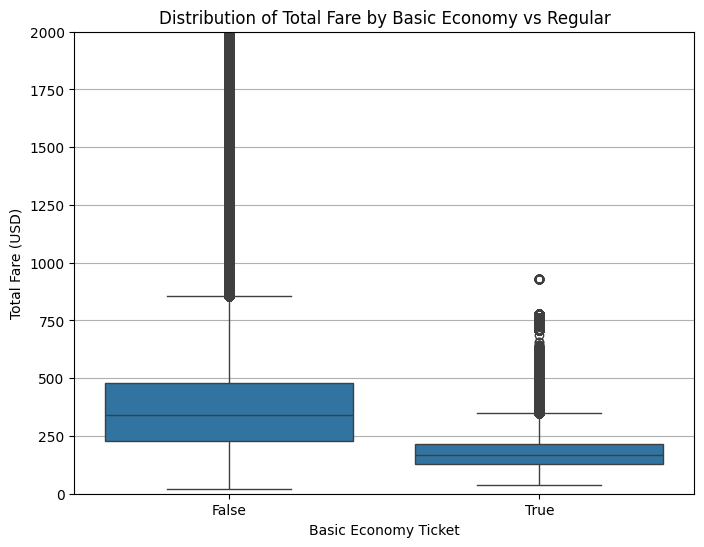

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Query: sample fares grouped by Basic Economy flag
df_basic = con.sql("""
    SELECT
        isBasicEconomy,
        totalFare
    FROM fp
""").df()

# Plot
plt.figure(figsize=(8,6))
sns.boxplot(data=df_basic, x="isBasicEconomy", y="totalFare")
plt.title("Distribution of Total Fare by Basic Economy vs Regular")
plt.xlabel("Basic Economy Ticket")
plt.ylabel("Total Fare (USD)")
plt.ylim(0, 2000)  # optional cap to avoid extreme outliers
plt.show()


### This cell samples the `fp` view to get `baseFare` and `totalFare` columns and creates a scatter plot using Seaborn to visualize the relationship between base fare and total fare.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

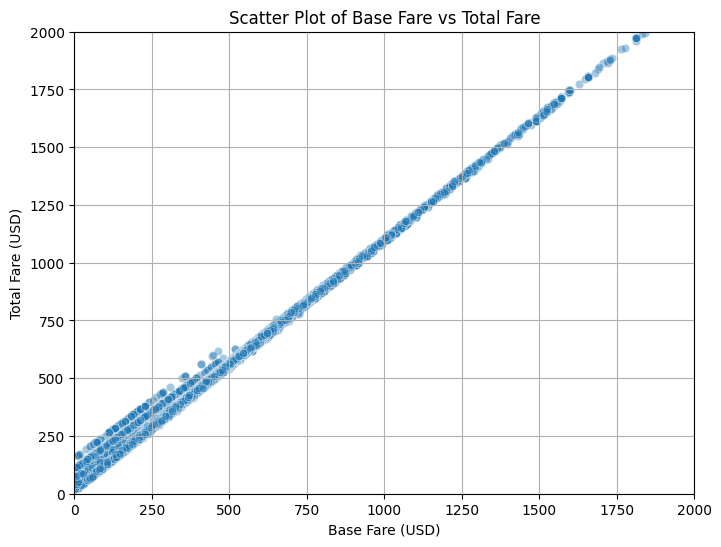

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Query: sample BaseFare and TotalFare
df_fares = con.sql("""
    SELECT
        baseFare,
        totalFare
    FROM fp
    USING SAMPLE 100000
""").df()

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_fares, x="baseFare", y="totalFare", alpha=0.4)
plt.title("Scatter Plot of Base Fare vs Total Fare")
plt.xlabel("Base Fare (USD)")
plt.ylabel("Total Fare (USD)")
plt.xlim(0, 2000)  # adjust as needed for readability
plt.ylim(0, 2000)
plt.show()


### This cell queries the `fp` view to calculate the average total fare for each flight date and creates a line plot using Seaborn to visualize the trend of average total fare over time.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

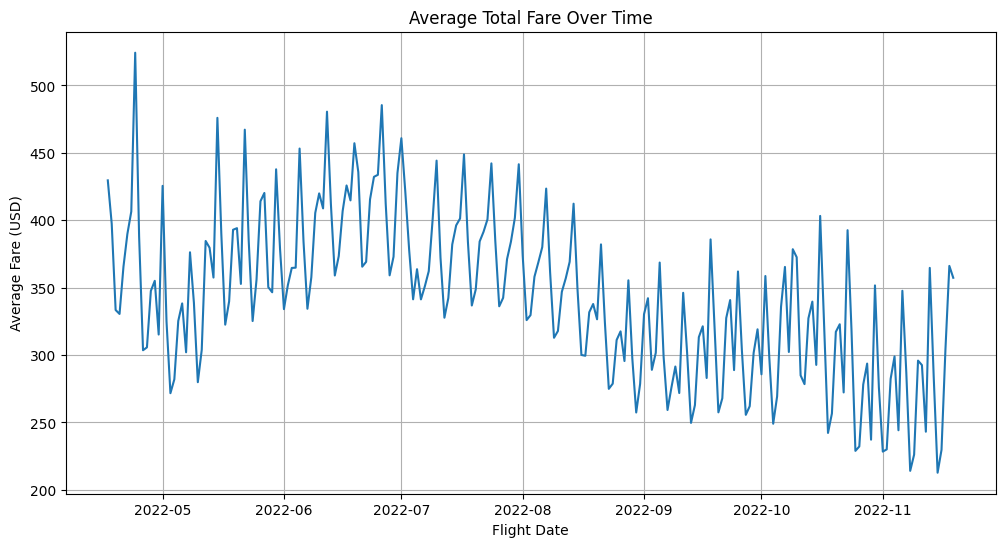

In [ ]:
df_trend = con.sql("""
    SELECT flightDate, AVG(totalFare) AS avg_fare
    FROM fp
    GROUP BY flightDate
    ORDER BY flightDate
""").df()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_trend, x="flightDate", y="avg_fare")
plt.title("Average Total Fare Over Time")
plt.xlabel("Flight Date")
plt.ylabel("Average Fare (USD)")
plt.show()


### This cell queries the `fp` view to get the top 20 airlines by flight count and visualizes the result as a bar plot using Seaborn.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

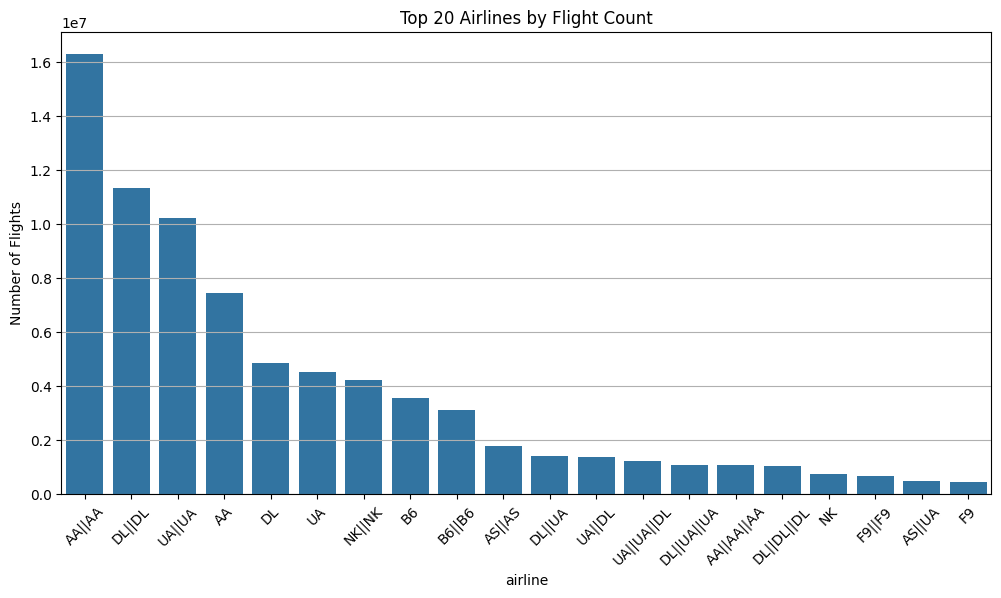

In [ ]:
df_airline = con.sql("""
    SELECT segmentsAirlineCode AS airline, COUNT(*) AS n
    FROM fp
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
""").df()

plt.figure(figsize=(12,6))
sns.barplot(data=df_airline, x="airline", y="n")
plt.title("Top 20 Airlines by Flight Count")
plt.xticks(rotation=45)
plt.ylabel("Number of Flights")
plt.show()


### This cell queries the `fp` view to calculate the average total fare for the top 20 airlines and visualizes the result as a bar plot using Seaborn.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

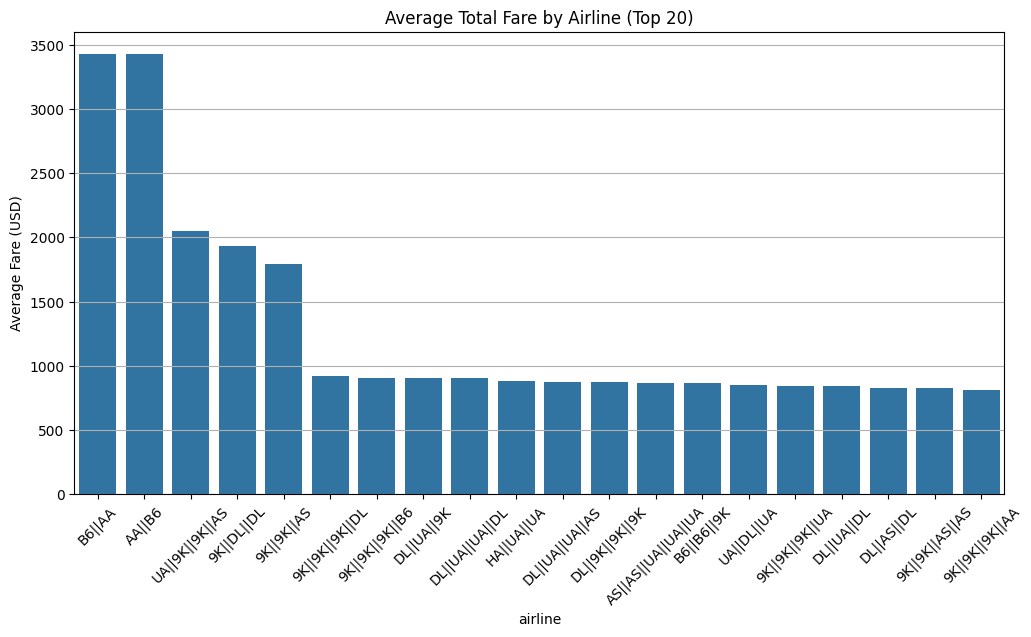

In [ ]:
df_airline_fare = con.sql("""
    SELECT segmentsAirlineCode AS airline, AVG(totalFare) AS avg_fare
    FROM fp
    GROUP BY 1
    ORDER BY avg_fare DESC
    LIMIT 20
""").df()

plt.figure(figsize=(12,6))
sns.barplot(data=df_airline_fare, x="airline", y="avg_fare")
plt.title("Average Total Fare by Airline (Top 20)")
plt.xticks(rotation=45)
plt.ylabel("Average Fare (USD)")
plt.show()


### This cell queries the `fp` view to get the top 20 flight routes by frequency and visualizes the result as a bar plot using Seab orn.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

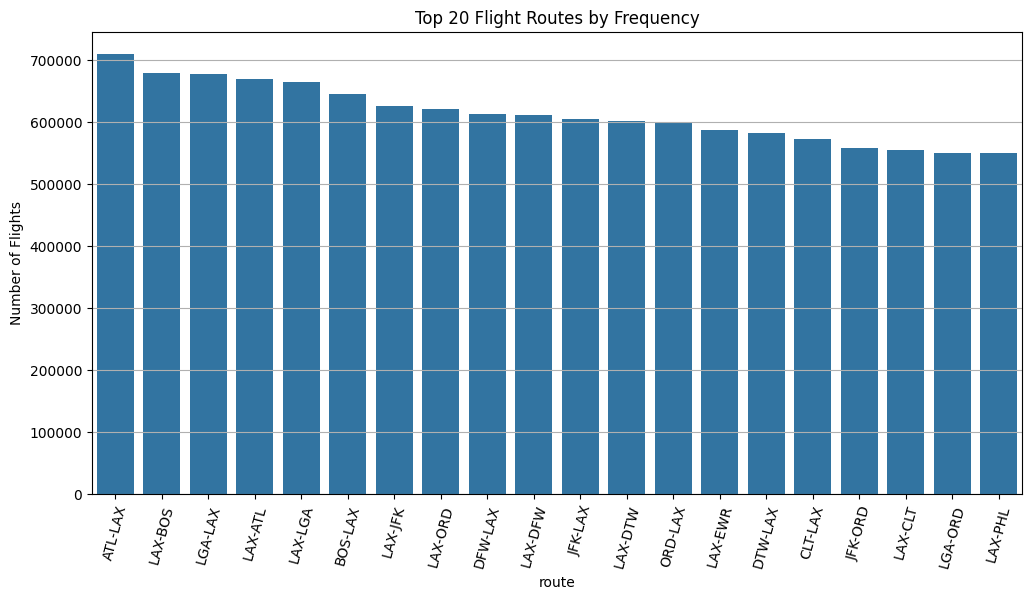

In [ ]:
df_routes = con.sql("""
    SELECT startingAirport || '-' || destinationAirport AS route, COUNT(*) AS n
    FROM fp
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
""").df()

plt.figure(figsize=(12,6))
sns.barplot(data=df_routes, x="route", y="n")
plt.title("Top 20 Flight Routes by Frequency")
plt.xticks(rotation=75)
plt.ylabel("Number of Flights")
plt.show()


### This cell samples the `fp` view to get the `seatsRemaining` column and creates a histogram using Seaborn to visualize the distribution of seats remaining

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

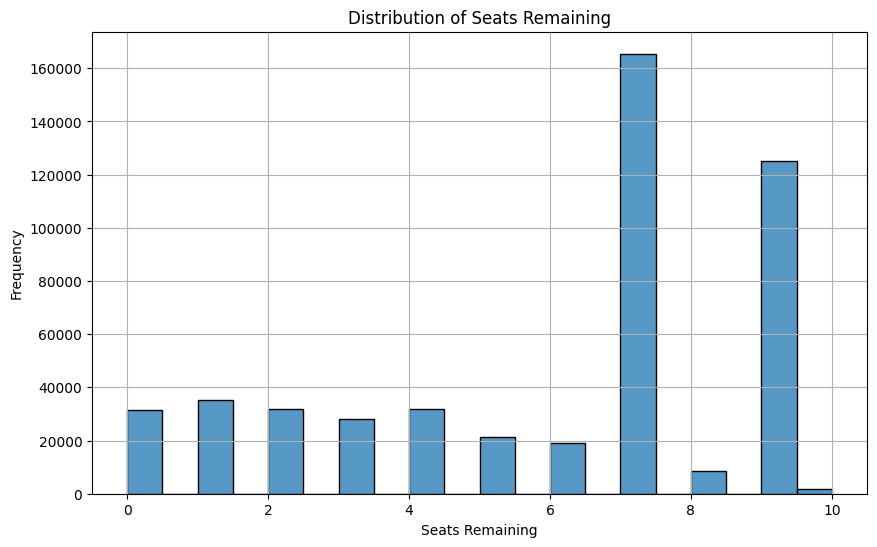

In [ ]:
df_seats = con.sql("""
    SELECT seatsRemaining
    FROM fp
    USING SAMPLE 500000
""").df()

plt.figure(figsize=(10,6))
sns.histplot(df_seats["seatsRemaining"], bins=20, kde=False)
plt.title("Distribution of Seats Remaining")
plt.xlabel("Seats Remaining")
plt.ylabel("Frequency")
plt.show()



### This cell queries the `fp` view to get the top 20 departure airports by frequency and visualizes the result as a bar plot using Seaborn.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

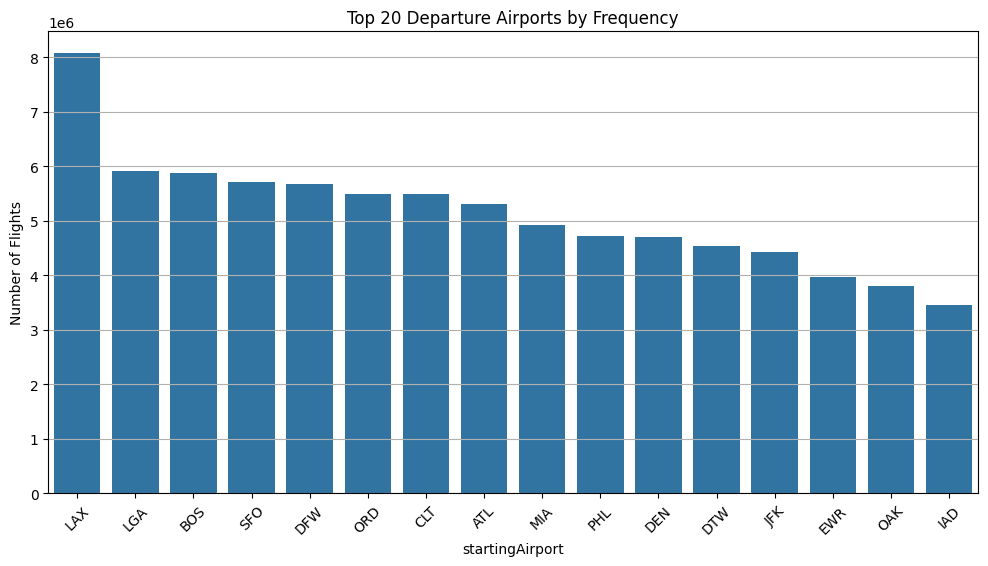

In [ ]:
df_depart = con.sql("""
    SELECT startingAirport, COUNT(*) AS n
    FROM fp
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
""").df()

plt.figure(figsize=(12,6))
sns.barplot(data=df_depart, x="startingAirport", y="n")
plt.title("Top 20 Departure Airports by Frequency")
plt.xticks(rotation=45)
plt.ylabel("Number of Flights")
plt.show()


### This cell queries the `fp` view to get the top 20 arrival airports by frequency and visualizes the result as a bar plot using Seaborn.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

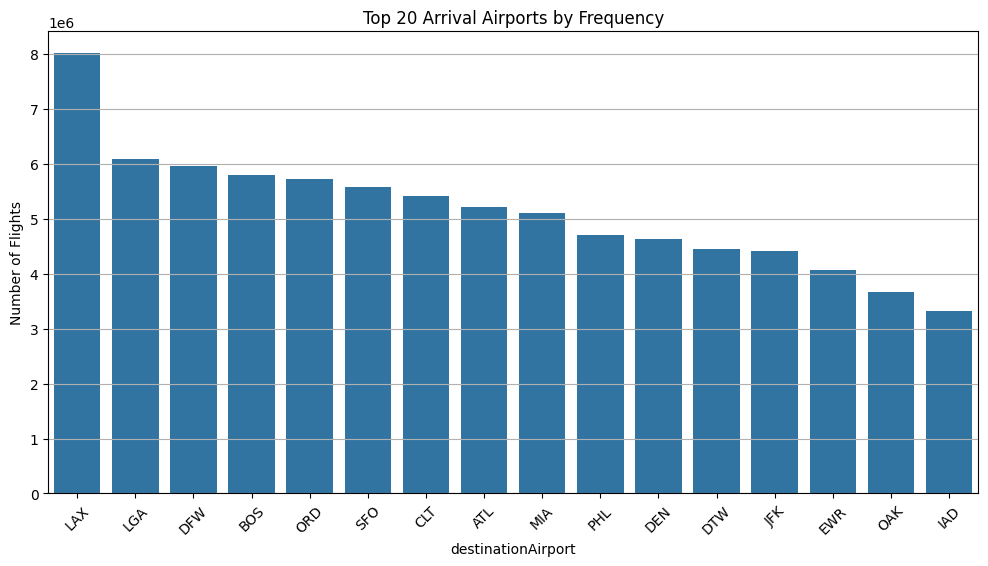

In [ ]:
df_arrive = con.sql("""
    SELECT destinationAirport, COUNT(*) AS n
    FROM fp
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
""").df()

plt.figure(figsize=(12,6))
sns.barplot(data=df_arrive, x="destinationAirport", y="n")
plt.title("Top 20 Arrival Airports by Frequency")
plt.xticks(rotation=45)
plt.ylabel("Number of Flights")
plt.show()


### This cell samples the `fp` view to get `totalTravelDistance` and `totalFare` columns and creates a scatter plot using Seaborn to visualize the relationship between travel distance and total fare.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

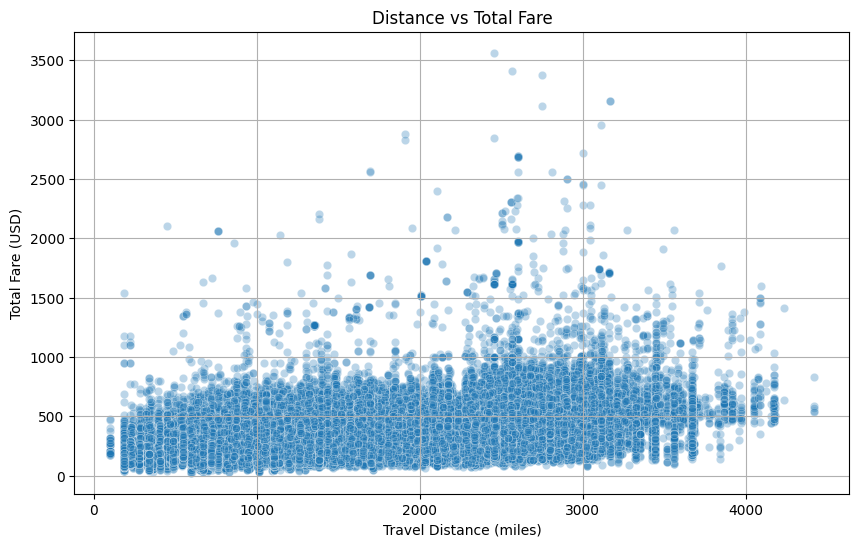

In [ ]:
df_dist_fare = con.sql("""
    SELECT totalTravelDistance AS dist, totalFare
    FROM fp
    USING SAMPLE 100000
""").df()

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_dist_fare, x="dist", y="totalFare", alpha=0.3)
plt.title("Distance vs Total Fare")
plt.xlabel("Travel Distance (miles)")
plt.ylabel("Total Fare (USD)")
plt.show()


### This cell queries the `fp` view to calculate the average fare by distance buckets and visualizes the result as a bar plot using Seaborn.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

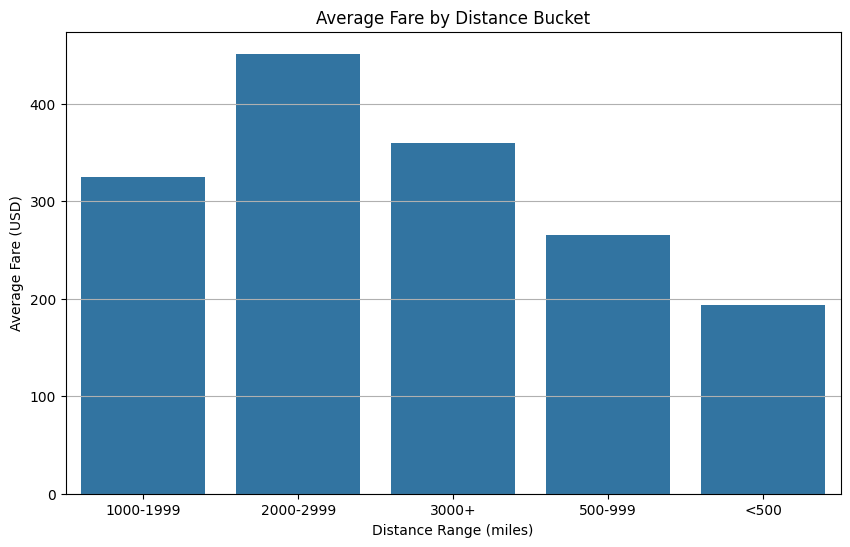

In [ ]:
df_dist_bucket = con.sql("""
    SELECT
        CASE
            WHEN totalTravelDistance < 500 THEN '<500'
            WHEN totalTravelDistance < 1000 THEN '500-999'
            WHEN totalTravelDistance < 2000 THEN '1000-1999'
            WHEN totalTravelDistance < 3000 THEN '2000-2999'
            ELSE '3000+' END AS dist_bucket,
        AVG(totalFare) AS avg_fare
    FROM fp
    GROUP BY 1
    ORDER BY 1
""").df()

plt.figure(figsize=(10,6))
sns.barplot(data=df_dist_bucket, x="dist_bucket", y="avg_fare")
plt.title("Average Fare by Distance Bucket")
plt.xlabel("Distance Range (miles)")
plt.ylabel("Average Fare (USD)")
plt.show()


### This cell samples the `fp` view to get the `totalTravelDistance` column and creates a histogram using Seaborn to visualize the distribution of travel distance.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

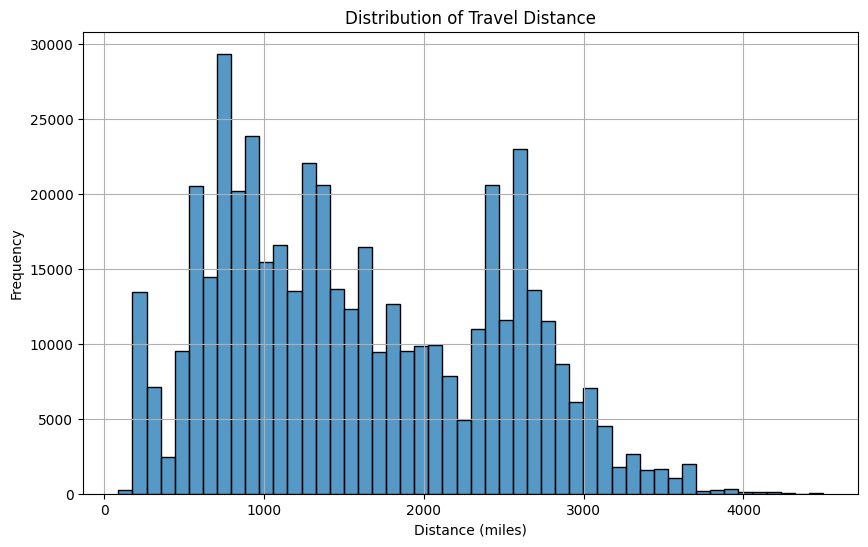

In [ ]:
df_dist = con.sql("""
    SELECT totalTravelDistance
    FROM fp
    USING SAMPLE 500000
""").df()

plt.figure(figsize=(10,6))
sns.histplot(df_dist["totalTravelDistance"], bins=50, kde=False)
plt.title("Distribution of Travel Distance")
plt.xlabel("Distance (miles)")
plt.ylabel("Frequency")
plt.show()


### This cell queries the `fp` view to calculate the average fare by day of the week and visualizes the result as a bar plot using Seaborn.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

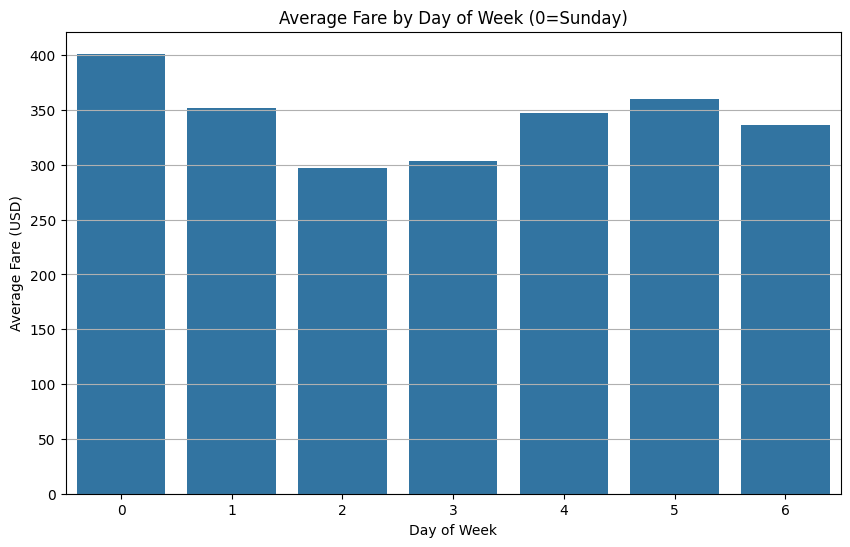

In [ ]:
df_dow = con.sql("""
    SELECT strftime(flightDate, '%w') AS dow, AVG(totalFare) AS avg_fare
    FROM fp
    GROUP BY 1
    ORDER BY 1
""").df()

plt.figure(figsize=(10,6))
sns.barplot(data=df_dow, x="dow", y="avg_fare")
plt.title("Average Fare by Day of Week (0=Sunday)")
plt.xlabel("Day of Week")
plt.ylabel("Average Fare (USD)")
plt.show()


### This cell samples the `fp` view to get the `elapsedDays` column and creates a histogram using Seaborn to visualize the distribution of elapsed days between search and flight dates.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

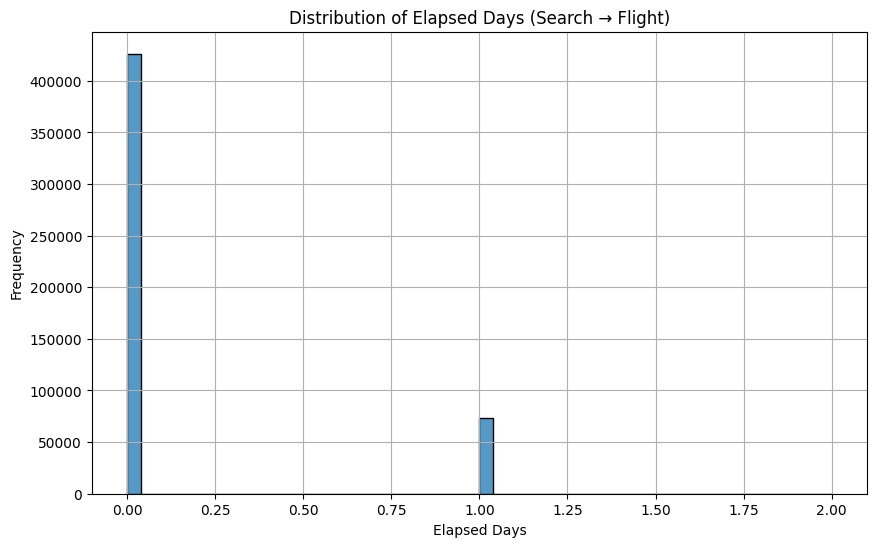

In [ ]:
df_elapsed = con.sql("""
    SELECT elapsedDays
    FROM fp
    USING SAMPLE 500000
""").df()

plt.figure(figsize=(10,6))
sns.histplot(df_elapsed["elapsedDays"], bins=50, kde=False)
plt.title("Distribution of Elapsed Days (Search → Flight)")
plt.xlabel("Elapsed Days")
plt.ylabel("Frequency")
plt.show()


### This cell queries the `fp` view to calculate the average fare by elapsed days (up to 90 days) and visualizes the result as a line plot using Seaborn.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

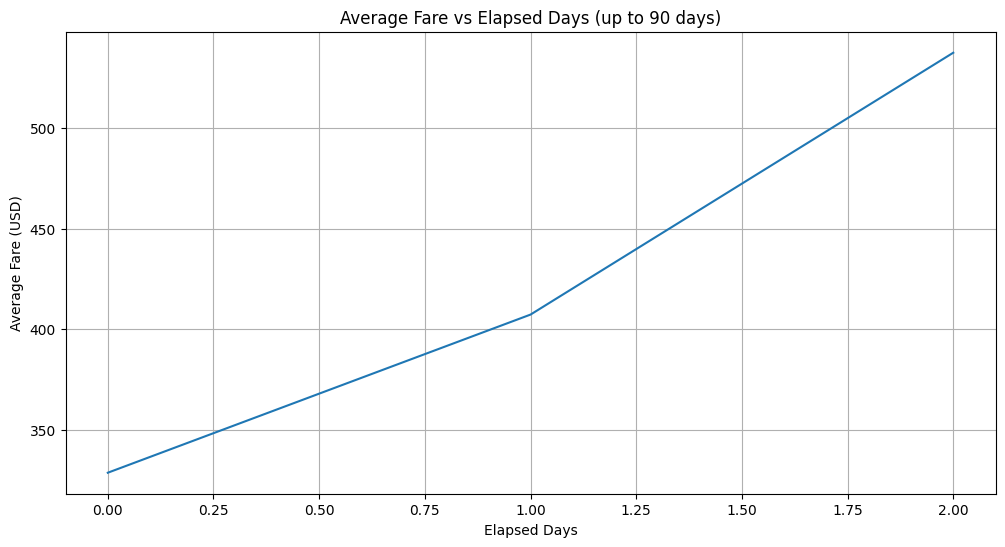

In [ ]:
df_elapsed_fare = con.sql("""
    SELECT elapsedDays, AVG(totalFare) AS avg_fare
    FROM fp
    GROUP BY 1
    HAVING elapsedDays BETWEEN 0 AND 90
    ORDER BY 1
""").df()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_elapsed_fare, x="elapsedDays", y="avg_fare")
plt.title("Average Fare vs Elapsed Days (up to 90 days)")
plt.xlabel("Elapsed Days")
plt.ylabel("Average Fare (USD)")
plt.show()


1. Descriptive statistics for numeric columns

### This cell calculates descriptive statistics (average, min, max, standard deviation, and count) for the `totalFare` column using the `fp` view.

In [ ]:
con.sql("""
SELECT
    AVG(totalFare) AS avg_totalFare,
    MIN(totalFare) AS min_totalFare,
    MAX(totalFare) AS max_totalFare,
    STDDEV(totalFare) AS std_totalFare,
    COUNT(totalFare) AS count_totalFare
FROM fp
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────────┬───────────────┬──────────────────┬─────────────────┐
│   avg_totalFare    │ min_totalFare │ max_totalFare │  std_totalFare   │ count_totalFare │
│       double       │    double     │    double     │      double      │      int64      │
├────────────────────┼───────────────┼───────────────┼──────────────────┼─────────────────┤
│ 340.38684915119444 │         19.59 │       8260.61 │ 196.029509911705 │        82138753 │
└────────────────────┴───────────────┴───────────────┴──────────────────┴─────────────────┘



2. Skewness & Kurtosis (distribution shape)

### This cell calculates the skewness and kurtosis for `totalFare` and `totalTravelDistance` columns using the `fp` view to understand the shape of their distributions.

In [ ]:
con.sql("""
SELECT
    skewness(totalFare) AS skew_totalFare,
    kurtosis(totalFare) AS kurt_totalFare,
    skewness(totalTravelDistance) AS skew_distance,
    kurtosis(totalTravelDistance) AS kurt_distance
FROM fp
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┬────────────────────┬────────────────────┬────────────────────┐
│  skew_totalFare   │   kurt_totalFare   │   skew_distance    │   kurt_distance    │
│      double       │       double       │       double       │       double       │
├───────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 2.102363253019691 │ 16.202300096356907 │ 0.3370339960754827 │ -0.897633407949833 │
└───────────────────┴────────────────────┴────────────────────┴────────────────────┘



3. Correlation between distance and fare

### This cell calculates the correlation coefficient between `totalFare` and `totalTravelDistance` columns using the `fp` view to understand the linear relationship between them.

In [ ]:
con.sql("""
SELECT corr(totalFare, totalTravelDistance) AS corr_fare_distance
FROM fp
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────┐
│ corr_fare_distance  │
│       double        │
├─────────────────────┤
│ 0.49261575041322486 │
└─────────────────────┘



4. Top 10 most common fareBasisCode values

### This cell queries the `fp` view to get the top 10 most common `fareBasisCode` values and their counts.


In [ ]:
con.sql("""
SELECT fareBasisCode, COUNT(*) AS n
FROM fp
GROUP BY 1
ORDER BY n DESC
LIMIT 10
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬─────────┐
│ fareBasisCode │    n    │
│    varchar    │  int64  │
├───────────────┼─────────┤
│ QAA0OKEN      │ 1386883 │
│ KAUOA0MQ      │  937072 │
│ V7AWZNN1      │  797408 │
│ QAA0OFEN      │  570964 │
│ HAA0OKEN      │  537443 │
│ G7AWZNN1      │  470363 │
│ KAVOA0MQ      │  438196 │
│ KA0NA0MC      │  398620 │
│ V0AHZNN1      │  393533 │
│ L0AIZNN1      │  369229 │
├───────────────┴─────────┤
│ 10 rows       2 columns │
└─────────────────────────┘



5. Distribution of boolean columns (proportions)

### This cell calculates the proportion of `isNonStop`, `isRefundable`, and `isBasicEconomy` columns using the `fp` view to understand the distribution of these boolean flags.


In [ ]:
con.sql("""
SELECT
    AVG(CASE WHEN isNonStop THEN 1 ELSE 0 END) AS pct_nonstop,
    AVG(CASE WHEN isRefundable THEN 1 ELSE 0 END) AS pct_refundable,
    AVG(CASE WHEN isBasicEconomy THEN 1 ELSE 0 END) AS pct_basicEconomy
FROM fp
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬────────────────────────┬─────────────────────┐
│    pct_nonstop     │     pct_refundable     │  pct_basicEconomy   │
│       double       │         double         │       double        │
├────────────────────┼────────────────────────┼─────────────────────┤
│ 0.2686537985303965 │ 1.6216462404779873e-05 │ 0.14396695308973098 │
└────────────────────┴────────────────────────┴─────────────────────┘



6. Average fare by booking horizon (elapsedDays buckets)

### This cell calculates the average fare by booking horizon buckets (`elapsedDays`) using the `fp` view.


In [ ]:
con.sql("""
SELECT
    CASE
        WHEN elapsedDays < 7 THEN '<1 week'
        WHEN elapsedDays < 30 THEN '1-4 weeks'
        WHEN elapsedDays < 90 THEN '1-3 months'
        ELSE '3+ months'
    END AS booking_window,
    AVG(totalFare) AS avg_fare,
    COUNT(*) AS n
FROM fp
WHERE elapsedDays IS NOT NULL
GROUP BY 1
ORDER BY 1
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────┬───────────────────┬──────────┐
│ booking_window │     avg_fare      │    n     │
│    varchar     │      double       │  int64   │
├────────────────┼───────────────────┼──────────┤
│ <1 week        │ 340.3868491512169 │ 82138753 │
└────────────────┴───────────────────┴──────────┘



7. Outlier detection thresholds (IQR method on totalFare)


### This cell calculates the Interquartile Range (IQR) based thresholds for outlier detection in the `totalFare` column using the `fp` view.

In [ ]:
# IQR-based bounds for totalFare (DuckDB syntax)
con.sql("""
WITH q AS (
  SELECT
    quantile(totalFare, 0.25) AS q1,
    quantile(totalFare, 0.75) AS q3
  FROM fp
  WHERE totalFare IS NOT NULL
)
SELECT
  q1,
  q3,
  (q3 - q1)                          AS iqr,
  (q1 - 1.5 * (q3 - q1))             AS lower_bound,
  (q3 + 1.5 * (q3 - q1))             AS upper_bound
FROM q
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬────────┬────────────────────┬─────────────────────┬───────────────────┐
│   q1   │   q3   │        iqr         │     lower_bound     │    upper_bound    │
│ double │ double │       double       │       double        │      double       │
├────────┼────────┼────────────────────┼─────────────────────┼───────────────────┤
│  197.1 │ 452.09 │ 254.98999999999998 │ -185.38499999999996 │ 834.5749999999999 │
└────────┴────────┴────────────────────┴─────────────────────┴───────────────────┘



### This cell counts the total number of rows and the number of outliers in the `totalFare` column based on the IQR thresholds calculated in the previous cell. It also calculates the outlier rate.

In [ ]:
con.sql("""
WITH q AS (
  SELECT
    quantile(totalFare, 0.25) AS q1,
    quantile(totalFare, 0.75) AS q3
  FROM fp
  WHERE totalFare IS NOT NULL
),
bounds AS (
  SELECT
    (q1 - 1.5 * (q3 - q1)) AS lower_bound,
    (q3 + 1.5 * (q3 - q1)) AS upper_bound
  FROM q
)
SELECT
  COUNT(*) AS n_total,
  SUM(CASE WHEN totalFare < lower_bound OR totalFare > upper_bound THEN 1 ELSE 0 END) AS n_outliers,
  CAST(SUM(CASE WHEN totalFare < lower_bound OR totalFare > upper_bound THEN 1 ELSE 0 END) AS DOUBLE)
    / NULLIF(COUNT(*), 0) AS outlier_rate
FROM fp, bounds
WHERE totalFare IS NOT NULL
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬────────────┬─────────────────────┐
│ n_total  │ n_outliers │    outlier_rate     │
│  int64   │   int128   │       double        │
├──────────┼────────────┼─────────────────────┤
│ 82138753 │    1191764 │ 0.01450915623225982 │
└──────────┴────────────┴─────────────────────┘



### This cell calculates various percentiles (10th, 25th, 50th (median), 75th, 90th, and 95th) for the `totalFare` column using the `fp` view to understand its distribution.

In [ ]:
con.sql("""
SELECT
  quantile(totalFare, 0.10) AS p10,
  quantile(totalFare, 0.25) AS p25,
  quantile(totalFare, 0.50) AS p50_median,
  quantile(totalFare, 0.75) AS p75,
  quantile(totalFare, 0.90) AS p90,
  quantile(totalFare, 0.95) AS p95
FROM fp
WHERE totalFare IS NOT NULL
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬────────┬────────────┬────────┬────────┬────────┐
│  p10   │  p25   │ p50_median │  p75   │  p90   │  p95   │
│ double │ double │   double   │ double │ double │ double │
├────────┼────────┼────────────┼────────┼────────┼────────┤
│  133.6 │  197.1 │      305.2 │ 452.09 │  578.6 │  665.1 │
└────────┴────────┴────────────┴────────┴────────┴────────┘



### This cell calculates various percentiles (10th, 25th, 50th (median), 75th, 90th, and 95th) for the `totalFare` column for the top 20 airlines using the `fp` view.

In [ ]:
con.sql("""
WITH top AS (
  SELECT segmentsAirlineCode AS airline
  FROM fp
  GROUP BY 1
  ORDER BY COUNT(*) DESC
  LIMIT 20
)
SELECT
  f.segmentsAirlineCode AS airline,
  quantile(f.totalFare, 0.10) AS p10,
  quantile(f.totalFare, 0.25) AS p25,
  quantile(f.totalFare, 0.50) AS p50_median,
  quantile(f.totalFare, 0.75) AS p75,
  quantile(f.totalFare, 0.90) AS p90,
  quantile(f.totalFare, 0.95) AS p95,
  COUNT(*) AS n
FROM fp f
JOIN top t ON f.segmentsAirlineCode = t.airline
WHERE f.totalFare IS NOT NULL
GROUP BY 1
ORDER BY n DESC
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────┬────────┬────────────┬────────┬────────┬─────────┬──────────┐
│  airline   │  p10   │  p25   │ p50_median │  p75   │  p90   │   p95   │    n     │
│  varchar   │ double │ double │   double   │ double │ double │ double  │  int64   │
├────────────┼────────┼────────┼────────────┼────────┼────────┼─────────┼──────────┤
│ AA||AA     │  151.6 │  199.1 │      287.6 │ 391.09 │  490.6 │  564.61 │ 16296340 │
│ DL||DL     │  171.6 │  247.6 │      357.6 │  487.6 │  611.6 │   712.1 │ 11351669 │
│ UA||UA     │  147.6 │  222.6 │      321.6 │  431.6 │ 529.19 │   591.6 │ 10217320 │
│ AA         │  118.6 │  163.6 │     233.61 │ 338.61 │  435.1 │   528.6 │  7453245 │
│ DL         │  108.6 │  153.6 │      228.6 │  328.6 │  458.6 │   518.6 │  4855169 │
│ UA         │  103.6 │  151.6 │      224.6 │  333.6 │  448.6 │   538.6 │  4531426 │
│ NK||NK     │  93.58 │ 132.58 │     193.58 │ 270.58 │ 339.58 │  380.58 │  4215514 │
│ B6         │   93.6 │  138.6 │      198.6 │  259.6 │  368.6 │  

NULL Values

### This cell queries the `fp` view to calculate the number of missing values for each column (treating `NULL` and empty strings as missing for VARCHARs) and displays the counts ordered by the highest number of missing values.


In [ ]:
# Missing counts per column (treat NULL or '' as missing for VARCHARs)
con.sql("""
WITH totals AS (SELECT COUNT(*) AS n FROM fp),
miss AS (
  SELECT
    SUM(CASE WHEN legId IS NULL OR length(trim(legId))=0 THEN 1 ELSE 0 END) AS legId_miss,
    SUM(CASE WHEN searchDate IS NULL THEN 1 ELSE 0 END) AS searchDate_miss,
    SUM(CASE WHEN flightDate IS NULL THEN 1 ELSE 0 END) AS flightDate_miss,
    SUM(CASE WHEN startingAirport IS NULL OR length(trim(startingAirport))=0 THEN 1 ELSE 0 END) AS startingAirport_miss,
    SUM(CASE WHEN destinationAirport IS NULL OR length(trim(destinationAirport))=0 THEN 1 ELSE 0 END) AS destinationAirport_miss,
    SUM(CASE WHEN fareBasisCode IS NULL OR length(trim(fareBasisCode))=0 THEN 1 ELSE 0 END) AS fareBasisCode_miss,
    SUM(CASE WHEN travelDuration IS NULL THEN 1 ELSE 0 END) AS travelDuration_miss,
    SUM(CASE WHEN elapsedDays IS NULL THEN 1 ELSE 0 END) AS elapsedDays_miss,
    SUM(CASE WHEN isBasicEconomy IS NULL THEN 1 ELSE 0 END) AS isBasicEconomy_miss,
    SUM(CASE WHEN isRefundable IS NULL THEN 1 ELSE 0 END) AS isRefundable_miss,
    SUM(CASE WHEN isNonStop IS NULL THEN 1 ELSE 0 END) AS isNonStop_miss,
    SUM(CASE WHEN baseFare IS NULL THEN 1 ELSE 0 END) AS baseFare_miss,
    SUM(CASE WHEN totalFare IS NULL THEN 1 ELSE 0 END) AS totalFare_miss,
    SUM(CASE WHEN seatsRemaining IS NULL THEN 1 ELSE 0 END) AS seatsRemaining_miss,
    SUM(CASE WHEN totalTravelDistance IS NULL THEN 1 ELSE 0 END) AS totalTravelDistance_miss,
    SUM(CASE WHEN segmentsDepartureTimeEpochSeconds IS NULL OR length(trim(segmentsDepartureTimeEpochSeconds))=0 THEN 1 ELSE 0 END) AS segDepEpoch_miss,
    SUM(CASE WHEN segmentsDepartureTimeRaw IS NULL OR length(trim(segmentsDepartureTimeRaw))=0 THEN 1 ELSE 0 END) AS segDepRaw_miss,
    SUM(CASE WHEN segmentsArrivalTimeEpochSeconds IS NULL OR length(trim(segmentsArrivalTimeEpochSeconds))=0 THEN 1 ELSE 0 END) AS segArrEpoch_miss,
    SUM(CASE WHEN segmentsArrivalTimeRaw IS NULL OR length(trim(segmentsArrivalTimeRaw))=0 THEN 1 ELSE 0 END) AS segArrRaw_miss,
    SUM(CASE WHEN segmentsArrivalAirportCode IS NULL OR length(trim(segmentsArrivalAirportCode))=0 THEN 1 ELSE 0 END) AS segArrAP_miss,
    SUM(CASE WHEN segmentsDepartureAirportCode IS NULL OR length(trim(segmentsDepartureAirportCode))=0 THEN 1 ELSE 0 END) AS segDepAP_miss,
    SUM(CASE WHEN segmentsAirlineName IS NULL OR length(trim(segmentsAirlineName))=0 THEN 1 ELSE 0 END) AS segAirName_miss,
    SUM(CASE WHEN segmentsAirlineCode IS NULL OR length(trim(segmentsAirlineCode))=0 THEN 1 ELSE 0 END) AS segAirCode_miss,
    SUM(CASE WHEN segmentsEquipmentDescription IS NULL OR length(trim(segmentsEquipmentDescription))=0 THEN 1 ELSE 0 END) AS segEquip_miss,
    SUM(CASE WHEN segmentsDurationInSeconds IS NULL THEN 1 ELSE 0 END) AS segDurSec_miss,
    SUM(CASE WHEN segmentsDistance IS NULL THEN 1 ELSE 0 END) AS segDist_miss,
    SUM(CASE WHEN segmentsCabinCode IS NULL OR length(trim(segmentsCabinCode))=0 THEN 1 ELSE 0 END) AS segCabin_miss
  FROM fp
)
SELECT * FROM (
  SELECT 'legId' AS col, legId_miss AS missing FROM miss UNION ALL
  SELECT 'searchDate', searchDate_miss FROM miss UNION ALL
  SELECT 'flightDate', flightDate_miss FROM miss UNION ALL
  SELECT 'startingAirport', startingAirport_miss FROM miss UNION ALL
  SELECT 'destinationAirport', destinationAirport_miss FROM miss UNION ALL
  SELECT 'fareBasisCode', fareBasisCode_miss FROM miss UNION ALL
  SELECT 'travelDuration', travelDuration_miss FROM miss UNION ALL
  SELECT 'elapsedDays', elapsedDays_miss FROM miss UNION ALL
  SELECT 'isBasicEconomy', isBasicEconomy_miss FROM miss UNION ALL
  SELECT 'isRefundable', isRefundable_miss FROM miss UNION ALL
  SELECT 'isNonStop', isNonStop_miss FROM miss UNION ALL
  SELECT 'baseFare', baseFare_miss FROM miss UNION ALL
  SELECT 'totalFare', totalFare_miss FROM miss UNION ALL
  SELECT 'seatsRemaining', seatsRemaining_miss FROM miss UNION ALL
  SELECT 'totalTravelDistance', totalTravelDistance_miss FROM miss UNION ALL
  SELECT 'segmentsDepartureTimeEpochSeconds', segDepEpoch_miss FROM miss UNION ALL
  SELECT 'segmentsDepartureTimeRaw', segDepRaw_miss FROM miss UNION ALL
  SELECT 'segmentsArrivalTimeEpochSeconds', segArrEpoch_miss FROM miss UNION ALL
  SELECT 'segmentsArrivalTimeRaw', segArrRaw_miss FROM miss UNION ALL
  SELECT 'segmentsArrivalAirportCode', segArrAP_miss FROM miss UNION ALL
  SELECT 'segmentsDepartureAirportCode', segDepAP_miss FROM miss UNION ALL
  SELECT 'segmentsAirlineName', segAirName_miss FROM miss UNION ALL
  SELECT 'segmentsAirlineCode', segAirCode_miss FROM miss UNION ALL
  SELECT 'segmentsEquipmentDescription', segEquip_miss FROM miss UNION ALL
  SELECT 'segmentsDurationInSeconds', segDurSec_miss FROM miss UNION ALL
  SELECT 'segmentsDistance', segDist_miss FROM miss UNION ALL
  SELECT 'segmentsCabinCode', segCabin_miss FROM miss
) x, totals
ORDER BY missing DESC
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────────────┬──────────┬──────────┐
│               col               │ missing  │    n     │
│             varchar             │  int128  │  int64   │
├─────────────────────────────────┼──────────┼──────────┤
│ travelDuration                  │ 82138753 │ 82138753 │
│ segmentsDistance                │ 60925084 │ 82138753 │
│ segmentsDurationInSeconds       │ 60071865 │ 82138753 │
│ totalTravelDistance             │  6094532 │ 82138753 │
│ segmentsEquipmentDescription    │  1557592 │ 82138753 │
│ startingAirport                 │        0 │ 82138753 │
│ flightDate                      │        0 │ 82138753 │
│ baseFare                        │        0 │ 82138753 │
│ destinationAirport              │        0 │ 82138753 │
│ totalFare                       │        0 │ 82138753 │
│     ·                           │        · │     ·    │
│     ·                           │        · │     ·    │
│     ·                           │        · │     ·    │
│ segmentsArri

### This cell creates the `fp_filled` view by replacing missing or empty values with sensible defaults—using median imputation for numeric fields and fallback constants (e.g., 'UNK', 'NA', 'Unknown Airline') for categorical/text fields—ensuring a cleaned dataset for downstream analysis.


In [ ]:
con.sql("""
CREATE OR REPLACE VIEW fp_filled AS
WITH med AS (
  SELECT
    COALESCE(quantile(baseFare, 0.5), 0) AS med_baseFare,
    COALESCE(quantile(totalFare, 0.5), 0) AS med_totalFare,
    COALESCE(quantile(seatsRemaining, 0.5), 0) AS med_seatsRemaining,
    COALESCE(quantile(totalTravelDistance, 0.5), 0) AS med_totalTravelDistance,
    COALESCE(quantile(travelDuration, 0.5), 0) AS med_travelDuration,
    COALESCE(quantile(elapsedDays, 0.5), 0) AS med_elapsedDays,
    COALESCE(quantile(segmentsDurationInSeconds, 0.5), 0) AS med_segDurSec,
    COALESCE(quantile(segmentsDistance, 0.5), 0) AS med_segDist
  FROM fp
)
SELECT
  COALESCE(NULLIF(trim(legId),''), 'UNKNOWN')                                  AS legId,
  searchDate                                                                    AS searchDate,  -- keep as-is
  COALESCE(flightDate, searchDate)                                              AS flightDate,  -- optional cross-fill
  COALESCE(NULLIF(trim(startingAirport),''), 'UNK')                             AS startingAirport,
  COALESCE(NULLIF(trim(destinationAirport),''), 'UNK')                          AS destinationAirport,
  COALESCE(NULLIF(trim(fareBasisCode),''), 'UNK')                               AS fareBasisCode,

  CAST(COALESCE(travelDuration, med.med_travelDuration) AS INTEGER)             AS travelDuration,
  CAST(COALESCE(elapsedDays, med.med_elapsedDays) AS INTEGER)                   AS elapsedDays,

  COALESCE(isBasicEconomy, FALSE)                                               AS isBasicEconomy,
  COALESCE(isRefundable, FALSE)                                                 AS isRefundable,
  COALESCE(isNonStop, FALSE)                                                    AS isNonStop,

  CAST(COALESCE(baseFare, med.med_baseFare) AS DOUBLE)                          AS baseFare,
  CAST(COALESCE(totalFare, med.med_totalFare) AS DOUBLE)                        AS totalFare,
  CAST(COALESCE(seatsRemaining, med.med_seatsRemaining) AS INTEGER)             AS seatsRemaining,
  CAST(COALESCE(totalTravelDistance, med.med_totalTravelDistance) AS DOUBLE)    AS totalTravelDistance,

  COALESCE(NULLIF(trim(segmentsDepartureTimeEpochSeconds),''), 'NA')            AS segmentsDepartureTimeEpochSeconds,
  COALESCE(NULLIF(trim(segmentsDepartureTimeRaw),''), 'NA')                     AS segmentsDepartureTimeRaw,
  COALESCE(NULLIF(trim(segmentsArrivalTimeEpochSeconds),''), 'NA')              AS segmentsArrivalTimeEpochSeconds,
  COALESCE(NULLIF(trim(segmentsArrivalTimeRaw),''), 'NA')                       AS segmentsArrivalTimeRaw,
  COALESCE(NULLIF(trim(segmentsArrivalAirportCode),''), 'UNK')                  AS segmentsArrivalAirportCode,
  COALESCE(NULLIF(trim(segmentsDepartureAirportCode),''), 'UNK')                AS segmentsDepartureAirportCode,
  COALESCE(NULLIF(trim(segmentsAirlineName),''), 'Unknown Airline')             AS segmentsAirlineName,
  COALESCE(NULLIF(trim(segmentsAirlineCode),''), 'UNK')                         AS segmentsAirlineCode,
  COALESCE(NULLIF(trim(segmentsEquipmentDescription),''), 'Unknown Equipment')  AS segmentsEquipmentDescription,

  CAST(COALESCE(segmentsDurationInSeconds, med.med_segDurSec) AS INTEGER)       AS segmentsDurationInSeconds,
  CAST(COALESCE(segmentsDistance, med.med_segDist) AS DOUBLE)                   AS segmentsDistance,
  COALESCE(NULLIF(trim(segmentsCabinCode),''), 'UNK')                            AS segmentsCabinCode
FROM fp, med
""")

print("✅ View 'fp_filled' created (NULLs/empties replaced with sensible defaults).")


✅ View 'fp_filled' created (NULLs/empties replaced with sensible defaults).


### This cell queries the `fp_filled` view to count the number of `NULL` values in each column after imputation, verifying that missing values were successfully handled in the data cleaning step.


In [ ]:
con.sql("""
SELECT
  SUM(legId IS NULL) AS legId_nulls,
  SUM(searchDate IS NULL) AS searchDate_nulls,
  SUM(flightDate IS NULL) AS flightDate_nulls,
  SUM(startingAirport IS NULL) AS startingAirport_nulls,
  SUM(destinationAirport IS NULL) AS destinationAirport_nulls,
  SUM(fareBasisCode IS NULL) AS fareBasisCode_nulls,
  SUM(travelDuration IS NULL) AS travelDuration_nulls,
  SUM(elapsedDays IS NULL) AS elapsedDays_nulls,
  SUM(isBasicEconomy IS NULL) AS isBasicEconomy_nulls,
  SUM(isRefundable IS NULL) AS isRefundable_nulls,
  SUM(isNonStop IS NULL) AS isNonStop_nulls,
  SUM(baseFare IS NULL) AS baseFare_nulls,
  SUM(totalFare IS NULL) AS totalFare_nulls,
  SUM(seatsRemaining IS NULL) AS seatsRemaining_nulls,
  SUM(totalTravelDistance IS NULL) AS totalTravelDistance_nulls,
  SUM(segmentsDepartureTimeEpochSeconds IS NULL) AS segDepEpoch_nulls,
  SUM(segmentsDepartureTimeRaw IS NULL) AS segDepRaw_nulls,
  SUM(segmentsArrivalTimeEpochSeconds IS NULL) AS segArrEpoch_nulls,
  SUM(segmentsArrivalTimeRaw IS NULL) AS segArrRaw_nulls,
  SUM(segmentsArrivalAirportCode IS NULL) AS segArrAP_nulls,
  SUM(segmentsDepartureAirportCode IS NULL) AS segDepAP_nulls,
  SUM(segmentsAirlineName IS NULL) AS segAirName_nulls,
  SUM(segmentsAirlineCode IS NULL) AS segAirCode_nulls,
  SUM(segmentsEquipmentDescription IS NULL) AS segEquip_nulls,
  SUM(segmentsDurationInSeconds IS NULL) AS segDurSec_nulls,
  SUM(segmentsDistance IS NULL) AS segDist_nulls,
  SUM(segmentsCabinCode IS NULL) AS segCabin_nulls
FROM fp_filled
""").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────────┬──────────────────┬───────────────────────┬──────────────────────────┬─────────────────────┬──────────────────────┬───────────────────┬──────────────────────┬────────────────────┬─────────────────┬────────────────┬─────────────────┬──────────────────────┬───────────────────────────┬───────────────────┬─────────────────┬───────────────────┬─────────────────┬────────────────┬────────────────┬──────────────────┬──────────────────┬────────────────┬─────────────────┬───────────────┬────────────────┐
│ legId_nulls │ searchDate_nulls │ flightDate_nulls │ startingAirport_nulls │ destinationAirport_nulls │ fareBasisCode_nulls │ travelDuration_nulls │ elapsedDays_nulls │ isBasicEconomy_nulls │ isRefundable_nulls │ isNonStop_nulls │ baseFare_nulls │ totalFare_nulls │ seatsRemaining_nulls │ totalTravelDistance_nulls │ segDepEpoch_nulls │ segDepRaw_nulls │ segArrEpoch_nulls │ segArrRaw_nulls │ segArrAP_nulls │ segDepAP_nulls │ segAirName_nulls │ segAirCode_nulls │ 

Outlier Removal

### This cell calculates the interquartile range (IQR) thresholds for `totalFare`, filters out rows outside these bounds to create the `fp_clean` table without outliers, and compares the row counts before and after cleaning.


In [ ]:
# Step 1: Compute IQR thresholds
bounds = con.sql("""
WITH q AS (
  SELECT
    quantile(totalFare, 0.25) AS q1,
    quantile(totalFare, 0.75) AS q3
  FROM fp
  WHERE totalFare IS NOT NULL
)
SELECT
  (q1 - 1.5 * (q3 - q1)) AS lower_bound,
  (q3 + 1.5 * (q3 - q1)) AS upper_bound
FROM q
""").df()

lower, upper = bounds.loc[0, "lower_bound"], bounds.loc[0, "upper_bound"]

print("Lower bound:", lower, "Upper bound:", upper)

# Step 2: Create a cleaned view without outliers
con.sql(f"""
CREATE OR REPLACE TABLE fp_clean AS
SELECT *
FROM fp
WHERE totalFare BETWEEN {lower} AND {upper}
""")

# Step 3: Check before vs after
print("Original rows:", con.sql("SELECT COUNT(*) AS n FROM fp").df().n[0])
print("Cleaned rows:", con.sql("SELECT COUNT(*) AS n FROM fp_clean").df().n[0])


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Lower bound: -185.38499999999996 Upper bound: 834.5749999999999


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Original rows: 82138753
Cleaned rows: 80946989


### This cell defines the source view for the data, the target column for prediction, and thresholds for one-hot encoding. It also asserts that the source view exists and displays the schema of the data.

In [ ]:
# Use the outlier-removed table as the source
SOURCE_VIEW = "fp_clean"
TARGET_COL = "totalFare"      # change if needed
OHE_THRESHOLD = 20            # one-hot if distinct <= this
OHE_MAX_LEVELS = 30           # safety cap per col

# Confirm source exists
assert ("fp_clean",) in con.sql("SHOW TABLES").fetchall(), "fp_clean not found. Create it first."

schema_df = con.sql(f"DESCRIBE {SOURCE_VIEW}").df()
schema_df


,column_name,column_type,null,key,default,extra
0,legId,VARCHAR,YES,None,None,None
1,searchDate,DATE,YES,None,None,None
2,flightDate,DATE,YES,None,None,None
3,startingAirport,VARCHAR,YES,None,None,None
4,destinationAirport,VARCHAR,YES,None,None,None
5,fareBasisCode,VARCHAR,YES,None,None,None
6,travelDuration,INTEGER,YES,None,None,None
7,elapsedDays,INTEGER,YES,None,None,None
8,isBasicEconomy,BOOLEAN,YES,None,None,None
9,isRefundable,BOOLEAN,YES,None,None,None


### This cell categorizes the columns based on their data types into numeric, boolean, date, and categorical columns. It also excludes 'legId' from categorical columns as it is an ID-like column.

In [ ]:
num_types = {"TINYINT","SMALLINT","INTEGER","BIGINT","HUGEINT","DOUBLE","FLOAT","DECIMAL","REAL"}
bool_types = {"BOOLEAN"}
date_types = {"DATE","TIMESTAMP","TIMESTAMP_NS","TIMESTAMP_S","TIMESTAMP_MS","TIMESTAMP_SEC"}

numeric_cols, bool_cols, date_cols, str_cols = [], [], [], []
for _,row in schema_df.iterrows():
    col = row["column_name"]
    dtype = str(row["column_type"]).upper()
    if any(k == dtype for k in bool_types):
        bool_cols.append(col)
    elif any(k in dtype for k in date_types):
        date_cols.append(col)
    elif any(k in dtype for k in num_types):
        numeric_cols.append(col)
    else:
        # assume VARCHAR or other string-like
        str_cols.append(col)

# drop ID-like column from cats
id_like = {"legId"}
str_cols = [c for c in str_cols if c not in id_like]

print("Numeric:", numeric_cols)
print("Boolean:", bool_cols)
print("Date:", date_cols)
print("Categorical:", str_cols)


Numeric: ['travelDuration', 'elapsedDays', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'segmentsDurationInSeconds', 'segmentsDistance']
Boolean: ['isBasicEconomy', 'isRefundable', 'isNonStop']
Date: ['searchDate', 'flightDate']
Categorical: ['startingAirport', 'destinationAirport', 'fareBasisCode', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsCabinCode']


### This cell calculates the number of distinct values (cardinality) for each categorical column and separates them into columns suitable for one-hot encoding (low cardinality) and label encoding (high cardinality).

In [ ]:
import pandas as pd

card_rows = []
for c in str_cols:
    n = con.sql(f"SELECT COUNT(DISTINCT {c}) AS n FROM {SOURCE_VIEW}").fetchone()[0]
    card_rows.append((c, int(n)))
card_df = pd.DataFrame(card_rows, columns=["column","n_distinct"]).sort_values("n_distinct", ascending=False)
display(card_df)

ohe_cols = [c for c,n in card_rows if n <= OHE_THRESHOLD]
le_cols  = [c for c,n in card_rows if n >  OHE_THRESHOLD]

print("One-Hot:", ohe_cols)
print("LabelEnc:", le_cols)


,column,n_distinct
6,segmentsArrivalTimeRaw,5202606
5,segmentsArrivalTimeEpochSeconds,5002078
4,segmentsDepartureTimeRaw,4701031
3,segmentsDepartureTimeEpochSeconds,4344398
2,fareBasisCode,20632
11,segmentsEquipmentDescription,11059
7,segmentsArrivalAirportCode,9966
8,segmentsDepartureAirportCode,9769
9,segmentsAirlineName,138
10,segmentsAirlineCode,138


One-Hot: ['startingAirport', 'destinationAirport']
LabelEnc: ['fareBasisCode', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsCabinCode']


### This cell generates SQL expressions to extract date-related features (year, month, day, day of week, is weekend, days ahead) from the date columns (`flightDate` and `searchDate`).

In [ ]:
date_exprs = []
if "flightDate" in date_cols:
    date_exprs += [
        "EXTRACT(YEAR  FROM flightDate)::INTEGER AS flight_year",
        "EXTRACT(MONTH FROM flightDate)::INTEGER AS flight_month",
        "EXTRACT(DAY   FROM flightDate)::INTEGER AS flight_day",
        "strftime(flightDate,'%w')::INTEGER AS flight_dow",
        "CASE WHEN strftime(flightDate,'%w') IN ('0','6') THEN 1 ELSE 0 END AS flight_is_weekend"
    ]
if "searchDate" in date_cols:
    date_exprs += [
        "EXTRACT(YEAR  FROM searchDate)::INTEGER AS search_year",
        "EXTRACT(MONTH FROM searchDate)::INTEGER AS search_month",
        "strftime(searchDate,'%w')::INTEGER AS search_dow"
    ]
# Booking horizon if dates exist (even though elapsedDays exists, compute days_ahead too)
if ("flightDate" in date_cols) and ("searchDate" in date_cols):
    date_exprs += ["DATEDIFF('day', searchDate, flightDate)::INTEGER AS days_ahead"]


### This cell imports necessary libraries from scikit-learn for model training, splitting data, and evaluating regression models.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### This cell defines the source view and target column for the modeling task and identifies initial high-signal features including numeric and boolean columns. It also asserts that the source view exists.


In [ ]:
assert (SOURCE_VIEW,) in con.sql("SHOW TABLES").fetchall(), f"{SOURCE_VIEW} not found."

# High-signal features (numeric + boolean + simple date flag)
num_cols  = ["baseFare", "totalTravelDistance", "travelDuration", "elapsedDays",
             "seatsRemaining", "segmentsDistance"]
bool_cols = ["isNonStop", "isBasicEconomy", "isRefundable"]


### This cell prepares the data for machine learning models by selecting features, handling missing values (filling with median), converting data types, and splitting the data into training and validation sets. It also defines a function `eval_model` to train and evaluate models.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SOURCE_VIEW = "fp_clean"
TARGET_COL  = "totalFare"
N_ROWS      = 82138753
TEST_SIZE   = 0.2
RAND_STATE  = 42

assert (SOURCE_VIEW,) in con.sql("SHOW TABLES").fetchall(), f"{SOURCE_VIEW} not found."

eligible = con.sql(f"SELECT COUNT(*) FROM {SOURCE_VIEW} WHERE {TARGET_COL} IS NOT NULL").fetchone()[0]
assert eligible > 0, "No rows with non-null target."
take = int(min(N_ROWS, eligible))

num_cols = [
    "baseFare","totalTravelDistance","travelDuration","elapsedDays",
    "seatsRemaining","segmentsDistance","segmentsDurationInSeconds"
]

feature_sql = f"""
WITH med AS (
  SELECT
    quantile(baseFare, 0.5)                    AS m_baseFare,
    quantile(totalTravelDistance, 0.5)         AS m_totalTravelDistance,
    quantile(travelDuration, 0.5)              AS m_travelDuration,
    quantile(elapsedDays, 0.5)                 AS m_elapsedDays,
    quantile(seatsRemaining, 0.5)              AS m_seatsRemaining,
    quantile(segmentsDistance, 0.5)            AS m_segmentsDistance,
    quantile(segmentsDurationInSeconds, 0.5)   AS m_segmentsDurationInSeconds
  FROM {SOURCE_VIEW}
  WHERE {TARGET_COL} IS NOT NULL
)
SELECT
  COALESCE(baseFare, m_baseFare)                                   AS baseFare,
  COALESCE(totalTravelDistance, m_totalTravelDistance)             AS totalTravelDistance,
  COALESCE(travelDuration, m_travelDuration)                       AS travelDuration,
  COALESCE(elapsedDays, m_elapsedDays)                             AS elapsedDays,
  COALESCE(seatsRemaining, m_seatsRemaining)                       AS seatsRemaining,
  COALESCE(segmentsDistance, m_segmentsDistance)                   AS segmentsDistance,
  COALESCE(segmentsDurationInSeconds, m_segmentsDurationInSeconds) AS segmentsDurationInSeconds,

  CAST(COALESCE(isNonStop, FALSE) AS INTEGER)       AS isNonStop_bin,
  CAST(COALESCE(isBasicEconomy, FALSE) AS INTEGER)  AS isBasicEconomy_bin,
  CAST(COALESCE(isRefundable, FALSE) AS INTEGER)    AS isRefundable_bin,

  COALESCE(DATEDIFF('day', searchDate, flightDate), elapsedDays, 0)::INTEGER AS days_ahead,
  CASE WHEN flightDate IS NOT NULL AND strftime(flightDate,'%w') IN ('0','6') THEN 1 ELSE 0 END AS flight_is_weekend,

  {TARGET_COL} AS target
FROM {SOURCE_VIEW}, med
WHERE {TARGET_COL} IS NOT NULL
USING SAMPLE {take} ROWS
"""

df = con.sql(feature_sql).df()
assert len(df) > 0, "No rows returned."

# Replace inf -> NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Coerce every feature to numeric, then fill residual NaNs
feature_cols = [c for c in df.columns if c != "target"]
for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median(numeric_only=True)).fillna(0)

# Target numeric & drop any accidental NaNs
y = pd.to_numeric(df["target"], errors="coerce")
mask = y.notna()
df = df.loc[mask]
y = y.loc[mask].astype("float32")

# Final features as float32 (prevents isnan type issues)
X = df[feature_cols].astype("float32")

# Sanity: ensure no NaNs remain (use pandas isna to avoid ufunc dtype issues)
assert not pd.isna(X).values.any(), "NaNs remain in X."
assert not pd.isna(y).values.any(), "NaNs remain in y."

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### This cell prepares the data for machine learning models by selecting features, handling missing values (filling with median), converting data types, and splitting the data into training and validation sets. It also defines a function `eval_model` to train and evaluate models.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RAND_STATE
)

def eval_model(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    mae  = mean_absolute_error(y_valid, pred)
    rmse = mean_squared_error(y_valid, pred)
    r2   = r2_score(y_valid, pred)
    print(f"{name:>28s} | rows: {len(X_train):7d} | feats: {X_train.shape[1]:3d} | "
          f"MAE: {mae:9.2f} | RMSE: {rmse:9.2f} | R²: {r2:7.4f}")

# Models (fast settings)
eval_model("LinearRegression", LinearRegression())

            LinearRegression | rows: 64757591 | feats:  12 | MAE:      7.72 | RMSE:    159.81 | R²:  0.9942


### This cell evaluates different regression models (Linear Regression, Ridge, RandomForestRegressor, HistGradientBoostingRegressor) on the prepared data and prints their performance metrics (MAE, RMSE, R²).

In [ ]:
eval_model("Ridge(alpha=1.0)", Ridge(alpha=1.0, random_state=RAND_STATE))
eval_model("RandomForestRegressor",
           RandomForestRegressor(
               n_estimators=120,
               max_depth=16,
               min_samples_leaf=2,
               n_jobs=-1,
               random_state=RAND_STATE
           ))
eval_model("HistGradientBoostingRegressor",
           HistGradientBoostingRegressor(
               learning_rate=0.08,
               max_iter=150,
               max_depth=None,
               random_state=RAND_STATE
           ))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.70867e-15): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


            Ridge(alpha=1.0) | rows: 64757591 | feats:  12 | MAE:      7.72 | RMSE:    159.81 | R²:  0.9942
       RandomForestRegressor | rows: 64757591 | feats:  12 | MAE:      2.07 | RMSE:     32.90 | R²:  0.9988
HistGradientBoostingRegressor | rows: 64757591 | feats:  12 | MAE:      3.03 | RMSE:     44.06 | R²:  0.9984


### This cell installs the TensorFlow library, which is used for building and training neural networks.


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 135.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 145.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 156.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 178.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


### This cell imports necessary libraries from TensorFlow and scikit-learn for building, training, evaluating neural network models, and scaling data.

In [ ]:
import numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next r

### This cell scales the training and validation data using StandardScaler, reshapes the data for sequence models (CNN, LSTM), defines an EarlyStopping callback, and builds, compiles, trains, and evaluates different neural network models (ANN, 1D-CNN, LSTM, LRCN, Bidirectional LSTM). It also reports their performance metrics.

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)

# Float32 for speed/memory
X_train_s = X_train_s.astype(np.float32)
X_valid_s = X_valid_s.astype(np.float32)
y_train_f = y_train.astype(np.float32).to_numpy().ravel()
y_valid_f = y_valid.astype(np.float32).to_numpy().ravel()

# Sequence view for CNN/LSTM-style models: (samples, steps, 1)
n_steps = X_train_s.shape[1]
X_train_seq = X_train_s.reshape((-1, n_steps, 1))
X_valid_seq = X_valid_s.reshape((-1, n_steps, 1))

early = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
tf.keras.utils.set_random_seed(42)

def report(name, model, Xv, yv):
    pred = model.predict(Xv, verbose=0).ravel()
    mae  = mean_absolute_error(yv, pred)
    mse  = mean_squared_error(yv, pred)    # older sklearn compat
    rmse = float(np.sqrt(mse))
    r2   = r2_score(yv, pred)
    print(f"{name:>20s} | MAE: {mae:9.2f} | RMSE: {rmse:9.2f} | R²: {r2:7.4f}")

# 1) ANN (Dense)
ann = models.Sequential([
    layers.Input(shape=(n_steps,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1),
])
ann.compile(optimizer="adam", loss="mse", metrics=["mae"])
ann.fit(X_train_s, y_train_f, validation_data=(X_valid_s, y_valid_f),
        epochs=20, batch_size=2048, callbacks=[early], verbose=0)
report("ANN", ann, X_valid_s, y_valid_f)

# 2) 1D-CNN
cnn = models.Sequential([
    layers.Input(shape=(n_steps,1)),
    layers.Conv1D(32, 3, padding="same", activation="relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation="relu"),
    layers.Dense(1),
])
cnn.compile(optimizer="adam", loss="mse", metrics=["mae"])
cnn.fit(X_train_seq, y_train_f, validation_data=(X_valid_seq, y_valid_f),
        epochs=20, batch_size=2048, callbacks=[early], verbose=0)
report("CNN1D", cnn, X_valid_seq, y_valid_f)

# 3) LSTM
lstm = models.Sequential([
    layers.Input(shape=(n_steps,1)),
    layers.LSTM(32),
    layers.Dense(16, activation="relu"),
    layers.Dense(1),
])
lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])
lstm.fit(X_train_seq, y_train_f, validation_data=(X_valid_seq, y_valid_f),
         epochs=20, batch_size=2048, callbacks=[early], verbose=0)
report("LSTM", lstm, X_valid_seq, y_valid_f)

# 4) LRCN (Conv1D -> LSTM)
lrcn = models.Sequential([
    layers.Input(shape=(n_steps,1)),
    layers.Conv1D(32, 3, padding="same", activation="relu"),
    layers.LSTM(32),
    layers.Dense(1),
])
lrcn.compile(optimizer="adam", loss="mse", metrics=["mae"])
lrcn.fit(X_train_seq, y_train_f, validation_data=(X_valid_seq, y_valid_f),
         epochs=20, batch_size=2048, callbacks=[early], verbose=0)
report("LRCN", lrcn, X_valid_seq, y_valid_f)

# 5) Bidirectional LSTM
bilstm = models.Sequential([
    layers.Input(shape=(n_steps,1)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(16, activation="relu"),
    layers.Dense(1),
])
bilstm.compile(optimizer="adam", loss="mse", metrics=["mae"])
bilstm.fit(X_train_seq, y_train_f, validation_data=(X_valid_seq, y_valid_f),
           epochs=20, batch_size=2048, callbacks=[early], verbose=0)
report("BiLSTM", bilstm, X_valid_seq, y_valid_f)

                 ANN | MAE:      2.84 | RMSE:      6.67 | R²:  0.9984
               CNN1D | MAE:      8.45 | RMSE:     12.47 | R²:  0.9944


### This cell prepares the data for binary classification by creating a binary target variable (high vs low fare) based on the training data median. It also scales the data and evaluates the trained models (ML and DL) on the binary classification task, reporting AUC, accuracy, and confusion matrix. Finally, it identifies the best performing model based on AUC and accuracy and saves it along with the scaler.

In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib, tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from typing import List, Tuple

# Preconditions
assert all(k in globals() for k in ["X_train","X_valid","y_train","y_valid"]), \
    "Need X_train/X_valid/y_train/y_valid from your previous training cell."

# 1) Make it binary: high-vs-low fare using TRAIN median (no leakage)
thr = float(np.median(y_train))
y_train_bin = (pd.Series(y_train).to_numpy().ravel() >= thr).astype(int)
y_valid_bin = (pd.Series(y_valid).to_numpy().ravel() >= thr).astype(int)

# 2) Recreate scaler for NN/LogReg-type inputs (inference only; no retrain)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_train_s = X_train_s.astype(np.float32)
X_valid_s = X_valid_s.astype(np.float32)

# Sequence view for CNN/LSTM style models
n_steps = X_train_s.shape[1]
X_train_seq = X_train_s.reshape((-1, n_steps, 1))
X_valid_seq = X_valid_s.reshape((-1, n_steps, 1))

def eval_from_scores(name, y_true, scores):
    s = np.asarray(scores).ravel()
    auc = roc_auc_score(y_true, s)
    # threshold at 0.5 if probs; otherwise normalize to [0,1] just for labels
    s_min, s_max = s.min(), s.max()
    probs = s if (s_min >= 0 and s_max <= 1) else (s - s_min) / (s_max - s_min + 1e-9)
    y_pred = (probs >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, s)
    print(f"{name:>20s} | AUC: {auc:.4f} | ACC: {acc:.4f} | CM: TN={cm[0,0]} FP={cm[0,1]} FN={cm[1,0]} TP={cm[1,1]}")
    return {"name": name, "auc": auc, "acc": acc, "cm": cm, "fpr": fpr, "tpr": tpr}

results: List[dict] = []

# 3) Evaluate any ML models you still have in memory (OPTIONAL)
#    If you previously kept references like rf, hgb, gbc, log_reg, ridge_clf etc., we’ll score them.
#    (We won't retrain anything here.)

def try_eval_ml(model, name, use_scaled=False):
    try:
        if model is None: return
        Xv = X_valid_s if use_scaled else X_valid
        # Try predict_proba; else decision_function; else raw predict (as score)
        if hasattr(model, "predict_proba"):
            scores = model.predict_proba(Xv)[:,1]
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(Xv)
        else:
            scores = model.predict(Xv)
        results.append(eval_from_scores(name, y_valid_bin, scores))
    except Exception as e:
        print(f"[skip {name}] {e}")

# Examples (only evaluated if you actually have these variables defined)
for name in ["log_reg","rf","hgbc","gbc","ridge_clf","svc_clf"]:
    try_eval_ml(globals().get(name, None), name=name, use_scaled=(name in {"log_reg","svc_clf","ridge_clf"}))

# 4) Evaluate DL models you trained earlier (ANN/CNN/LSTM/LRCN/BiLSTM)
def try_eval_dl(model, name, kind="flat"):
    try:
        if model is None: return
        if kind == "flat":
            scores = model.predict(X_valid_s, verbose=0).ravel()
        else:
            scores = model.predict(X_valid_seq, verbose=0).ravel()
        results.append(eval_from_scores(name, y_valid_bin, scores))
    except Exception as e:
        print(f"[skip {name}] {e}")

# Only evaluate the ones that exist in your session
try_eval_dl(globals().get("ann", None),   "ANN",   kind="flat")
try_eval_dl(globals().get("cnn", None),   "CNN1D", kind="seq")
try_eval_dl(globals().get("lstm", None),  "LSTM",  kind="seq")
try_eval_dl(globals().get("lrcn", None),  "LRCN",  kind="seq")
try_eval_dl(globals().get("bilstm", None),"BiLSTM",kind="seq")

# 5) Plot ROC for everything that was evaluated
if results:
    plt.figure(figsize=(8,6))
    for res in results:
        plt.plot(res["fpr"], res["tpr"], label=f"{res['name']} (AUC={res['auc']:.3f})")
    plt.plot([0,1],[0,1],'--',alpha=0.6)
    plt.title("ROC Curves (Validation)"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No trained models detected in memory to evaluate.")

# 6) Pick best by AUC (tie-break ACC), then save weights
def save_best(best_name, best_kind, model_obj, scaler_obj=None):
    os.makedirs("/content/models", exist_ok=True)
    if best_kind == "ml":
        path = "/content/models/best_model.pkl"
        joblib.dump(model_obj, path)
        if scaler_obj is not None:
            joblib.dump(scaler_obj, "/content/models/scaler.pkl")
        print(f"Saved ML model to: {path}")
    else:
        path = "/content/models/best_model.h5"
        model_obj.save(path)
        if scaler_obj is not None:
            joblib.dump(scaler_obj, "/content/models/scaler.pkl")
        print(f"Saved DL model to: {path}")
    if scaler_obj is not None:
        print("Saved scaler to: /content/models/scaler.pkl")

if results:
    # map name -> object & type to save
    name_to_obj = {
        "ANN":    ("dl", globals().get("ann", None)),
        "CNN1D":  ("dl", globals().get("cnn", None)),
        "LSTM":   ("dl", globals().get("lstm", None)),
        "LRCN":   ("dl", globals().get("lrcn", None)),
        "BiLSTM": ("dl", globals().get("bilstm", None)),
        # ML examples, only if you kept them:
        "log_reg":("ml", globals().get("log_reg", None)),
        "rf":     ("ml", globals().get("rf", None)),
        "hgbc":   ("ml", globals().get("hgbc", None)),
        "gbc":    ("ml", globals().get("gbc", None)),
        "ridge_clf":("ml", globals().get("ridge_clf", None)),
        "svc_clf":  ("ml", globals().get("svc_clf", None)),
    }
    # choose best
    best = sorted(results, key=lambda r: (r["auc"], r["acc"]), reverse=True)[0]
    best_kind, best_obj = name_to_obj.get(best["name"], (None, None))
    print(f"\nBest model: {best['name']} | AUC={best['auc']:.4f} | ACC={best['acc']:.4f}")
    if best_kind and best_obj is not None:
        save_best(best["name"], best_kind, best_obj, scaler_obj=scaler)
    else:
        print("Model object not found in memory — nothing saved.")

### This cell performs time series forecasting of the average daily fare using the SARIMAX model. It aggregates the data to daily frequency, handles missing dates, splits the data into training and validation sets, fits the SARIMAX model, backtests on the validation set, and refits the model on the full dataset before saving it. It also generates an optional future forecast.

In [ ]:
import os, numpy as np, pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

SOURCE_VIEW = "fp_clean"
HORIZON_DAYS = 30   # forecast horizon & backtest window (last 30 days)
MODEL_PATH = "/content/models/sarimax_fare_forecast.pkl"

# Optional route filter (set both to None for global average)
ROUTE_START = None  # e.g., "JFK"
ROUTE_DEST  = None  # e.g., "LAX"

# --- 1) Build daily time series from DuckDB (aggregate on the fly; very memory-friendly)
route_clause = ""
if ROUTE_START and ROUTE_DEST:
    route_clause = f"AND startingAirport='{ROUTE_START}' AND destinationAirport='{ROUTE_DEST}'"

sql = f"""
SELECT
  flightDate::DATE AS ds,
  AVG(totalFare)   AS y
FROM {SOURCE_VIEW}
WHERE totalFare IS NOT NULL
  AND flightDate IS NOT NULL
  {route_clause}
GROUP BY 1
ORDER BY 1
"""
ts = con.sql(sql).df()

# --- 2) Make a continuous daily index; fill missing days by interpolation (if any)
ts["ds"] = pd.to_datetime(ts["ds"])
ts = ts.set_index("ds").sort_index()
full_idx = pd.date_range(ts.index.min(), ts.index.max(), freq="D")
ts = ts.reindex(full_idx)
ts.columns = ["y"]
# interpolate gaps (linear), and back/forward fill edges if needed
ts["y"] = ts["y"].interpolate(method="linear").bfill().ffill()

# Ensure we have enough history
assert len(ts) > HORIZON_DAYS + 30, "Not enough history to train & backtest."

# --- 3) Train/validation split (last HORIZON_DAYS for validation)
train = ts.iloc[:-HORIZON_DAYS]
valid = ts.iloc[-HORIZON_DAYS:]

# --- 4) Fit SARIMAX with weekly seasonality (7-day)
# Keep the model small & fast; relax stationarity constraints for robustness
model = sm.tsa.statespace.SARIMAX(
    endog=train["y"],
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# --- 5) Backtest on the last HORIZON_DAYS
pred = res.get_forecast(steps=HORIZON_DAYS).predicted_mean
pred.index = valid.index  # align indices

rmse = float(np.sqrt(mean_squared_error(valid["y"].values, pred.values)))
mape = float(np.mean(np.abs((valid["y"].values - pred.values) / np.maximum(1e-6, valid["y"].values))) * 100.0)

print(f"Validation (last {HORIZON_DAYS} days)  RMSE: {rmse:,.2f}   MAPE: {mape:,.2f}%")

# --- 6) Refit on full data and save the model
final_model = sm.tsa.statespace.SARIMAX(
    endog=ts["y"],
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_res = final_model.fit(disp=False)

os.makedirs("/content/models", exist_ok=True)
final_res.save(MODEL_PATH)
print(f"✅ Saved forecasting model to: {MODEL_PATH}")

# --- 7) (Optional) Produce a 30-day future forecast now
future_fc = final_res.get_forecast(steps=HORIZON_DAYS).predicted_mean
future_fc = future_fc.rename("forecast").to_frame()
display(future_fc.head())


### This cell copies the CSV file from Google Drive to the local Colab environment.


In [ ]:
import os

source_path = "/content/drive/MyDrive/extracted_archive/itineraries.csv"
destination_dir = "/content/data/"
destination_path = os.path.join(destination_dir, os.path.basename(source_path))

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the file
!cp "{source_path}" "{destination_path}"

print(f"Copied '{source_path}' to '{destination_path}'")

Copied '/content/drive/MyDrive/extracted_archive/itineraries.csv' to '/content/data/itineraries.csv'


### This cell checks the size of the copied CSV file in the local Colab environment.

In [ ]:
file_path = "/content/data/itineraries.csv"
!du -h "{file_path}"

29G	/content/data/itineraries.csv
